# Project Overview
A fully automated Python pipeline for quantifying collagen fiber morphology across 10 different metrics and four experimental conditions. Includes data preprocessing, outlier removal, statistical testing (ANOVA, PCA), and generation of publication-ready visualizations.

# Import Required Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data Loading and Preprocessing

In [2]:
# read
df = pd.read_csv("/content/Picrosirius_WB_AllParams.csv")
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation
0,46_MXD_WB_L1,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [3]:
# convert from pixels to microns
conversion_factor = 0.124 # ~0.124 µm/pixel

df["Length"] = df["Length"] * conversion_factor
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation
0,46_MXD_WB_L1,7.5,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,6.8,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,7.7,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,7.4,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,6.7,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [4]:
# create new "Condition" column from "Slide" column
df['Condition'] = df['Slide'].str.split('_').str[1]
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation,Condition
0,46_MXD_WB_L1,7.5,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,MXD
1,46_MXD_WB_L1_2,6.8,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,MXD
2,46_MXD_WB_L2,7.7,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,MXD
3,46_MXD_WB_L2_2,7.4,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,MXD
4,46_MXD_WB_R1,6.7,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,MXD


In [5]:
# to compare before and after filtering outliers
df.describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,6.817094,7.803097,0.948974,104.010256,93.683761,647.914530,0.812650,0.743420,0.556923,105.143590
std,0.383561,1.536901,0.010536,46.349470,82.188246,231.601381,0.125199,0.116813,0.175231,55.593178
min,5.900000,4.786400,0.910000,30.500000,6.000000,242.000000,0.100000,0.166100,0.030000,13.400000
25%,6.500000,6.658800,0.940000,43.500000,34.000000,486.000000,0.770000,0.717100,0.430000,33.500000
50%,6.800000,7.613600,0.950000,133.000000,70.000000,620.000000,0.830000,0.755500,0.530000,139.000000
75%,7.000000,8.556000,0.960000,138.300000,111.000000,750.000000,0.910000,0.813700,0.700000,146.900000
max,8.200000,12.288400,0.970000,149.600000,352.000000,1328.000000,0.980000,0.917900,0.920000,161.700000


# Outlier Removal

In [6]:
# filter outliers function (+/- 2 STD)
# returns list of indices corresponding to outliers in a specific column
def get_outliers_col(df, column, n_std=2):
    mean = df[column].mean()
    std = df[column].std()
    lower = mean - n_std * std
    upper = mean + n_std * std
    ls = df.index[(df[column] <= lower) | (df[column] >= upper)]
    return ls

In [7]:
# function that removes rows containing outliers by index
def remove_outliers(df, indices):
  df_filtered = df.drop(index = indices)
  return df_filtered

In [8]:
# apply function
# create a new df for each filtered column
filtered_dfs = {}
cols_to_filter = ['Length', 'Alignment_CA', 'Kurtosis', 'FeatNumCA']
for col in cols_to_filter:
  outliers = get_outliers_col(df, col)
  filtered_df = remove_outliers(df, outliers)
  filtered_dfs[col] = filtered_df

# validate
filtered_dfs['Length'].describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,6.811607,7.625446,0.948839,106.923214,90.714286,637.133929,0.807946,0.739404,0.554464,108.427679
std,0.390829,1.310594,0.010548,45.211084,81.455059,226.070207,0.125749,0.117352,0.175514,54.539460
min,5.900000,4.786400,0.910000,30.500000,6.000000,242.000000,0.100000,0.166100,0.030000,13.400000
25%,6.500000,6.606100,0.940000,49.350000,32.500000,476.000000,0.760000,0.712700,0.430000,36.250000
50%,6.800000,7.576400,0.950000,133.900000,66.000000,593.500000,0.820000,0.754950,0.530000,139.950000
75%,7.000000,8.500200,0.960000,138.425000,107.250000,734.500000,0.900000,0.809725,0.700000,147.300000
max,8.200000,10.837600,0.970000,149.600000,352.000000,1328.000000,0.980000,0.917900,0.920000,161.700000


In [9]:
# map complete names for conditions to their short forms
# actual conditions are removed for IP reasons (publication in progress)
name_map = {
    'MXD': 'Condition 1',
    'SXD': 'Condition 2',
    'AXD': 'Condition 3',
    'PXD': 'Condition 4'
}

for col, df_filtered in filtered_dfs.items():
  df_filtered['Condition'] = df_filtered['Condition'].map(name_map)

# Statistical Testing
* ANOVA, Tukey's HSD  



In [10]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# define the metric to analyze
dependent_variable = "Length"

# one-way ANOVA for selected metric
C1 = df_filtered[df_filtered["Condition"] == "Condition 1"][dependent_variable]
C2 = df_filtered[df_filtered["Condition"] == "Condition 2"][dependent_variable]
C3 = df_filtered[df_filtered["Condition"] == "Condition 3"][dependent_variable]
C4 = df_filtered[df_filtered["Condition"] == "Condition 4"][dependent_variable]

In [11]:
f_stat, p_val = f_oneway(C1, C2, C3, C4)
print(f"F-statistic: {f_stat}, p-value: {p_val}")

# tukey's HSD post-hoc test
data = pd.concat([C1, C2, C3, C4], ignore_index=True)
labels = (
    ['Condition 1'] * len(C1) +
    ['Condition 2'] * len(C2) +
    ['Condition 3'] * len(C3) +
    ['Condition 4'] * len(C4)
)
tukey = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
print(tukey)

F-statistic: 12.067435791563364, p-value: 7.396966929648443e-07
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
Condition 1 Condition 2   2.0925    0.0  1.1312  3.0538   True
Condition 1 Condition 3   0.3382 0.7313 -0.5174  1.1938  False
Condition 1 Condition 4   0.7763   0.11 -0.1137  1.6663  False
Condition 2 Condition 3  -1.7543    0.0 -2.6839 -0.8247   True
Condition 2 Condition 4  -1.3162 0.0029 -2.2775 -0.3549   True
Condition 3 Condition 4   0.4381 0.5419 -0.4175  1.2938  False
--------------------------------------------------------------


# Data Visualization

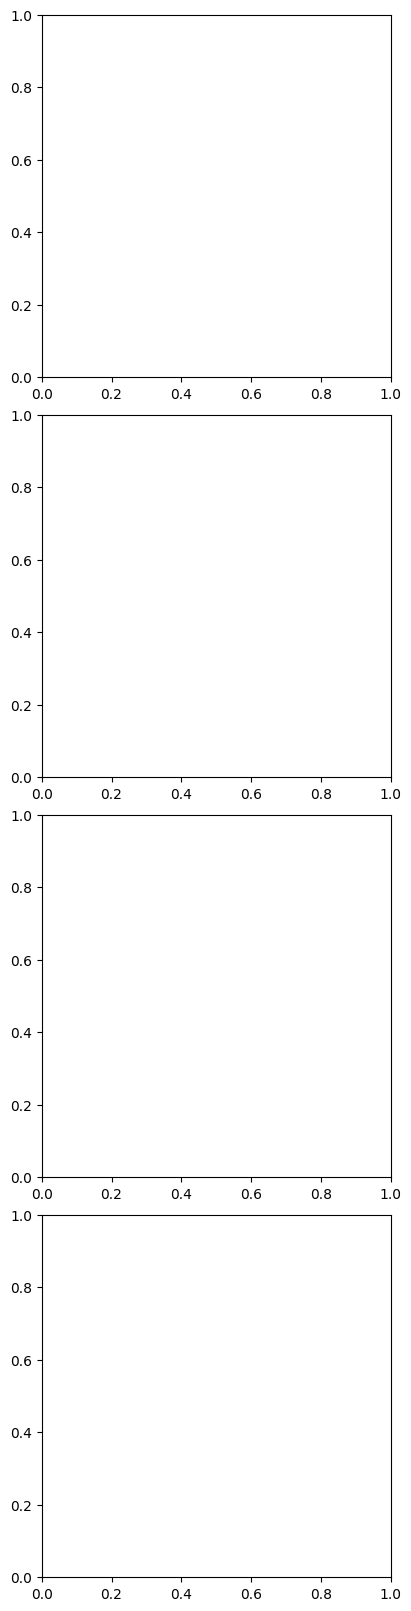

In [12]:
# panel setup
fig, axes = plt.subplots(4,1,figsize = (4,16), constrained_layout=True)

# x and y label font size
font_size = 24

# order of conditions displayed on plot
desired_order = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4']

# custom color way
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]

In [13]:
# Length plot
dependent_variable = "Length"
plt.figure(figsize=(4,4))

# set position on panel
ax = axes[0]

# plot barplot
ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
                 y=dependent_variable, errorbar='sd', capsize=0.1,
                 order = desired_order, palette=custom_palette, legend=False,
                 edgecolor = '0.2', lw = 2.5, errwidth = 2.5, ax = ax)
max_val = filtered_dfs[dependent_variable][dependent_variable].max()

# plot points on the bar graph
sns.swarmplot(data = filtered_dfs[dependent_variable], x = 'Condition',
              y = dependent_variable, marker = "s", fc = 'None',
              edgecolor = '0.2', linewidth = 1, ax = ax)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# remove x ticks and labels (bottommost graph will have x ticks and labels)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel(None)

# emphasize y ticks and labels
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',
                  color = '0.2')
ax.set_ylabel("Length (µm)", size = font_size, weight = 'bold', color = '0.2')
ax.set_ylim(top = 12)

# define interval to use in bracket and asterisk relative spacing
ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)

# plot brackets
ax.plot([0,0,1,1],
         [max_val + 0.5*interval, max_val + interval, max_val + interval,
          max_val + 0.5*interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,2,2],
         [max_val + interval, max_val + 1.5*interval, max_val + 1.5*interval,
          max_val + interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,3,3],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval,
          max_val + 1.5*interval], lw=2.5, color='0.2', clip_on=False)

# plot asterisks
alignment = 'right'
size = 18
ax.text(x=1, y=max_val + interval + interval/50, s="***", ha=alignment,
         size=size, weight='bold')
ax.text(x=2, y=max_val + 1.5*interval + interval/50, s="****", ha=alignment,
         size=size, weight='bold')
ax.text(x=3, y=max_val + 2*interval + interval/50, s="**", ha=alignment,
         size=size, weight='bold')

<ipython-input-13-316391402>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
<ipython-input-13-316391402>:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',


Tick interval: 2.0


<ipython-input-13-316391402>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',


Text(3, 14.8776, '**')

<Figure size 400x400 with 0 Axes>

In [14]:
# Alignment plot
dependent_variable = "Alignment_CA"
plt.figure(figsize=(4,4))

# set position on panel
ax = axes[1]

# plot bar plot
ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
                 y=dependent_variable, errorbar='sd', capsize=0.1,
                 order = desired_order, palette=custom_palette, legend=False,
                 edgecolor = '0.2', lw = 2.5, errwidth = 2.5, ax = ax)
max_val = filtered_dfs[dependent_variable][dependent_variable].max()

# plot points on the bar graph
sns.swarmplot(data = filtered_dfs[dependent_variable], x = 'Condition',
              y = dependent_variable, marker = "s", fc = 'None',
              edgecolor = '0.2', linewidth = 1, ax = ax)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# remove x ticks and labels (bottommost graph will have x ticks and labels)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel(None)

# emphasize y ticks and labels
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',
                  color = '0.2')
ax.set_ylabel("Alignment", size = font_size, weight = 'bold', color = '0.2')
ax.set_ylim(top = 1)

# define interval to use in bracket and asterisk relative spacing
ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)

# plot brackets
ax.plot([0,0,1,1],
         [max_val + 0.5*interval, max_val + interval, max_val + interval,
          max_val + 0.5*interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,2,2],
         [max_val + interval, max_val + 1.5*interval, max_val + 1.5*interval,
          max_val + interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,3,3],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval,
          max_val + 1.5*interval], lw=2.5, color='0.2', clip_on=False)

# plot asterisks
alignment = 'right'
size = 18
ax.text(x=1, y=max_val + interval + interval/50, s="***", ha=alignment,
         size=size, weight='bold')
ax.text(x=2, y=max_val + 1.5*interval + interval/50, s="****", ha=alignment,
         size=size, weight='bold')
ax.text(x=3, y=max_val + 2*interval + interval/50, s="**", ha=alignment,
         size=size, weight='bold')

<ipython-input-14-2874785457>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
<ipython-input-14-2874785457>:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',


Tick interval: 0.2


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-14-2874785457>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',


Text(3, 1.384, '**')

<Figure size 400x400 with 0 Axes>

In [15]:
# Kurtosis plot

dependent_variable = "Kurtosis"
plt.figure(figsize=(4,4))

# set position on panel
ax = axes[2]

# plot barplot
ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
                 y=dependent_variable, errorbar='sd', capsize=0.1,
                 order = desired_order, palette=custom_palette, legend=False,
                 edgecolor = '0.2', lw = 2.5, errwidth = 2.5, ax = ax)
max_val = filtered_dfs[dependent_variable][dependent_variable].max()

# plot points on the bar graph
sns.swarmplot(data = filtered_dfs[dependent_variable], x = 'Condition',
              y = dependent_variable, marker = "s", fc = 'None',
              edgecolor = '0.2', linewidth = 1, ax = ax)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# remove x ticks and labels (bottommost graph will have x ticks and labels)
font_size = 24
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel(None)

# emphasize y ticks and labels
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',
                  color = '0.2')
ax.set_ylabel("Kurtosis", size = font_size, weight = 'bold', color = '0.2')
ax.set_ylim(top = max_val+interval/2)

# define interval to use in bracket and asterisk relative spacing
ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)

# plot brackets (y-values moved up by 0.5*interval)
ax.plot([0,0,1,1],
         [max_val + 0.5*interval, max_val + interval, max_val + interval,
          max_val + 0.5*interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,2,2],
         [max_val + interval, max_val + 1.5*interval, max_val + 1.5*interval,
          max_val + interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,3,3],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval,
          max_val + 1.5*interval], lw=2.5, color='0.2', clip_on=False)

# plot asterisks (y-values moved up by 0.5*interval)
alignment = 'right'
size = 18
ax.text(x=1, y=max_val + interval + interval/50, s="***", ha=alignment,
         size=size, weight='bold')
ax.text(x=2, y=max_val + 1.5*interval + interval/50, s="****", ha=alignment,
         size=size, weight='bold')
ax.text(x=3, y=max_val + 2*interval + interval/50, s="**", ha=alignment,
         size=size, weight='bold')

<ipython-input-15-745103104>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
<ipython-input-15-745103104>:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',


Tick interval: 0.2


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-15-745103104>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',


Text(3, 1.304, '**')

<Figure size 400x400 with 0 Axes>

In [16]:
# FeatNumCA plot

dependent_variable = "FeatNumCA"
plt.figure(figsize=(4,4))

# set position on panel
ax = axes[3]
ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
                 y=dependent_variable, errorbar='sd', capsize=0.1,
                 order = desired_order, palette=custom_palette, legend=False,
                 edgecolor = '0.2', lw = 2.5, errwidth = 2.5, ax = ax)
max_val = filtered_dfs[dependent_variable][dependent_variable].max()

# plot points on the bar graph
sns.swarmplot(data = filtered_dfs[dependent_variable], x = 'Condition',
              y = dependent_variable, marker = "s", fc = 'None',
              edgecolor = '0.2', linewidth = 1, ax = ax)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rotate x tick labels and emphasize style
font_size = 24
ax.set_xticklabels(ax.get_xticklabels(), size = font_size, rotation = 35,
                  rotation_mode = 'anchor', ha = 'right', weight = 'bold',
                  color = '0.2')

# emphasize y ticks and labels
ax.set_yticklabels(ax.get_yticklabels(), size = font_size, weight = 'bold',
                  color = '0.2')
ax.set_xlabel(None)
ax.set_ylabel("Feature Number", size = font_size, weight = 'bold', color = '0.2')
ax.set_ylim(top = 1200)

# define interval to use in bracket and asterisk relative spacing
ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)

# plot brackets
ax.plot([0,0,1,1],
         [max_val + interval, max_val + 1.5*interval, max_val + 1.5*interval,
          max_val + interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([0,0,2,2],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval,
          max_val + 1.5*interval], lw=2.5, color='0.2', clip_on=False)

ax.plot([2,2,3,3],
         [max_val + 0.5*interval, max_val + interval, max_val + interval,
          max_val + 0.5*interval], lw=2.5, color='0.2', clip_on=False)

# plot asterisks
alignment = 'right'
size = 18
ax.text(x=1, y=max_val + 1.5*interval + interval/50, s="**", ha=alignment,
         size=size, weight='bold')
ax.text(x=2, y=max_val + 2*interval + interval/50, s="**", ha=alignment,
         size=size, weight='bold')
ax.text(x=3, y=max_val + interval + interval/50, s="*", ha=alignment,
         size=size, weight='bold')

# export figure panel
fig.savefig("Panel.png", bbox_inches = 'tight', dpi = 600,
            facecolor = ax.get_facecolor())

<ipython-input-16-310033546>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
<ipython-input-16-310033546>:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=filtered_dfs[dependent_variable], x='Condition',
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-16-310033546>:30: U

Tick interval: 200.0


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed

<Figure size 400x400 with 0 Axes>